# Toy 1d Example for Review Paper

In [1]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import jax
import jax.numpy as jnp
import jax.random as jr
import gpjax as gpx
from scipy.stats import qmc
from numpy.random import default_rng
import matplotlib.pyplot as plt
import seaborn as sns

from numpyro.distributions import LogNormal
from jax.scipy.stats import norm

from uncprop.utils.grid import Grid, DensityComparisonGrid, normalize_density_over_grid
from uncprop.core.inverse_problem import Prior, Posterior
from uncprop.core.distribution import DistributionFromDensity
from uncprop.utils.gpjax_models import construct_gp
from uncprop.utils.distribution import _gaussian_log_density_tril
from uncprop.utils.other import _numpy_rng_seed_from_jax_key
from uncprop.utils.gpjax_multioutput import BatchedRBF
from uncprop.models.vsem.surrogate import _estimate_ep_grid

from uncprop.core.surrogate import (
    construct_design, 
    GPJaxSurrogate, 
    FwdModelGaussianSurrogate,
    LogDensGPSurrogate,
    LogDensClippedGPSurrogate,
)
from uncprop.utils.plot import (
    set_plot_theme, 
    smart_subplots,
    plot_gp_1d,
    plot_marginal_pred_1d,
)

base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')
out_dir = base_dir / 'out' / 'review_final'

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings

In [2]:
key = jr.key(325234)

# plot settings
n_grid = 100

# exact inverse problem
noise_sd = 0.1
time_horizon = (-3, 3)
support = (0, 1)
true_param = 0.5
n_time = 8

# surrogate settings
x_design = jnp.array([0.0, 0.4, 0.9]).reshape(-1, 1) # [0.4, 0.8, 0.9]
jitter = 0.0

In [3]:
# Plotting
interval_prob = 0.95
post_ylim = (0.0, 0.3)

gp_colors = {
    "mean":     "#AA3377",
    "interval": "#EEBBDD",
    "points":   "#888888",
    "true":     "#000000"
}

colors = set_plot_theme()

# sns.set_theme(style='ticks', palette='colorblind')
sns.set_context(
    "paper",
    font_scale=2.0,
    rc={"lines.linewidth": 3,
        "axes.linewidth": 1.5}
)

import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


## Helper Functions

In [4]:
def wrap_gp(gp, design, jitter):
    """Wrap single output gpjax GP as batch GPJaxSurrogate object"""
    ker = gp.prior.kernel
    batched_kernel = BatchedRBF(batch_dim=1, input_dim=ker.n_dims,
                                lengthscale=ker.lengthscale,
                                variance=ker.variance)
    batched_gp_prior = gpx.gps.Prior(mean_function=gp.prior.mean_function,
                                     kernel=batched_kernel)
    batched_gp_post = batched_gp_prior * gp.likelihood
    return GPJaxSurrogate(gp=batched_gp_post, design=design, jitter=jitter)

In [5]:
class FwdModelGaussianSurrogateGrid(FwdModelGaussianSurrogate):
    """Posterior surrogate induced by forward model surrogate
    
    Defines method to approximate EP over a grid.
    """
    def expected_normalized_density_approx(self,
                                           key,
                                           *,
                                           grid,
                                           n_mc: int = 10_000,
                                           **method_kwargs):

        cell_area = grid.cell_area
        input_dim = self.surrogate.input_dim
        y = self.y
        noise_cov_tril = self.noise_cov_tril

        def log_dens(x):
            log_post_samp = self._sample_lpost(key, x, n=n_mc)
            return _estimate_ep_grid(log_post_samp, cell_area=cell_area)

        return DistributionFromDensity(log_dens=log_dens, dim=input_dim)

    def _sample_lpost(self, key, x, n=1):
        """Sample realizations of unnormalized log-posterior surrogate at finite set of points"""
        fwd_samp = self.surrogate(x).sample(key, n=n) # (n, n_x)
        log_prior_dens = self.log_prior(x)

        y = self.y
        noise_cov_tril = self.noise_cov_tril

        log_lik_vals = jnp.zeros(fwd_samp.shape)
        for i in range(fwd_samp.shape[1]):
            l = _gaussian_log_density_tril(y, m=fwd_samp[:,i].reshape(-1,1), L=noise_cov_tril)
            log_lik_vals = log_lik_vals.at[:,i].set(l)

        log_post_samp = log_prior_dens + log_lik_vals
        return log_post_samp


class LogDensGPSurrogateGrid(LogDensGPSurrogate):
    """Posterior surrogate induced by log-density surrogate
    
    Defines method to approximate EP over a grid.
    """
    def expected_normalized_density_approx(self,
                                           key,
                                           *,
                                           grid,
                                           n_mc: int = 10_000,
                                           **method_kwargs):
        
            cell_area = grid.cell_area
            input_dim = self.surrogate.input_dim

            def log_dens(x):
                log_post_samp = self.surrogate(x).sample(key, n=n_mc) # (n_mc, n_x)
                return _estimate_ep_grid(log_post_samp, cell_area=cell_area)

            return DistributionFromDensity(log_dens=log_dens, dim=input_dim)
    
    def _sample_lpost(self, key, x, n=1):
        """Sample realizations of unnormalized log-posterior surrogate at finite set of points"""
        return self.surrogate(x).sample(key, n=n) # (n, n_x)

In [6]:
import matplotlib.ticker as ticker

def plot_lognorm_1d(x,
                    mean,
                    sd,
                    colors=None,
                    points=None,
                    true_y=None,
                    interval_prob=0.95,
                    interval_alpha=0.3):
    """
    Plot lognormal process marginals, using log-scale for y-axis.
    true_y should be on log-scale.
    """
    # log of lognormal mean
    log_mean_ln = mean + 0.5 * (sd**2)
    
    # log of lognormal confidence interval bounds
    z = norm.ppf(1 - (1 - interval_prob) / 2)
    log_lower = mean - z * sd
    log_upper = mean + z * sd

    fig, ax = plot_marginal_pred_1d(x=x,
                                    mean=log_mean_ln,
                                    lower=log_lower,
                                    upper=log_upper,
                                    colors=colors,
                                    points=points,
                                    true_y=true_y,
                                    interval_alpha=interval_alpha)

    # Force ticks to land on nice powers of 10
    ln_10 = jnp.log(10)
    tick_spacing = ln_10 * 200
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Format the label to show 10^integer
    def log_formatter(x, pos):
        exponent = x / ln_10
        return f"$10^{{{int(round(exponent))}}}$"

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_formatter))

    return fig, ax

In [7]:
def get_density_grid(key, grid, post_em, post_true):
    dists = {
        'exact': post_true,
        'mean': post_em.expected_surrogate_approx(),
        'eup': post_em.expected_density_approx(),
        'ep': post_em.expected_normalized_density_approx(key, grid=grid)
    }

    return DensityComparisonGrid(grid=grid, distributions=dists)


def save_post_approx_plot(post_em, dens_grid, out_dir, 
                          filename_label, post_colors, post_ylim=None):
    """Save posterior approximation plot."""
    # posterior approximation plot
    fig_approx, ax_approx = dens_grid.plot(normalized=True, 
                                           log_scale=False, 
                                           points=post_em.surrogate.design.X,
                                           colors=post_colors)
    
    ax_approx.set_ylabel('pi(u)')
    if post_ylim is not None:
        ax_approx.set_ylim(post_ylim)
    
    fig_approx.savefig(out_dir / f'post_approx_{filename_label}.png', bbox_inches='tight')


def save_surrogate_plot(post_em, f_target, grid, gp_colors, 
                        filename_label, target_label, interval_prob=0.95):
    """Save plot summarizing underlying emulator distribution
    
    Agnostic to the underlying surrogate model. `f_target` is the true target
    function that is emulated.
    """
    surr = post_em.surrogate
    pred = surr(grid.flat_grid)
    fig_em, ax_em = plot_gp_1d(x=grid.flat_grid.ravel(),
                               mean=pred.mean,
                               sd=pred.stdev,
                               points=surr.design.X,
                               true_y=f_target(grid.flat_grid),
                               colors=gp_colors,
                               interval_prob=interval_prob)
    ax_em.set_ylabel(target_label)
    fig_em.savefig(out_dir / f'gp_dist_{filename_label}.png', bbox_inches='tight')

    return (fig_em, ax_em), pred


def save_norm_post_surrogate_plots(key, post_em, post_true, grid, filename_label,
                                   n_mc=int(1e5), interval_prob=0.95):
    lpost_samp = post_em._sample_lpost(key, grid.flat_grid, n=n_mc) # (n_mc, n_x)
    trajectories, _ = normalize_density_over_grid(lpost_samp, cell_area=grid.cell_area, return_log=False)

    q_lower = 0.5 * (1 - interval_prob)
    lower = jnp.quantile(trajectories, q=q_lower, axis=0)
    upper = jnp.quantile(trajectories, q=1-q_lower, axis=0)
    mean = jnp.mean(trajectories, axis=0)
    post_true, _ = normalize_density_over_grid(post_true.log_density(grid.flat_grid),
                                               cell_area=grid.cell_area, return_log=False)

    fig, ax = plot_marginal_pred_1d(x=grid.flat_grid.ravel(),
                                    mean=mean,
                                    lower=lower,
                                    upper=upper,
                                    points=post_em.surrogate.design.X,
                                    true_y=post_true.ravel(),
                                    colors=gp_colors)
    ax.set_xlabel('u')
    ax.set_ylabel('pi(u)')
    fig.savefig(out_dir / f'post_norm_dist_{filename_label}.png', bbox_inches='tight')

    return lpost_samp


def save_ldens_em_plots(key, grid, f_target, post_em, post_true, out_dir, gp_colors, 
                        post_colors, interval_prob, n_mc=int(1e5), **kwargs):
    """
    Surrogate plots for log-density emulator
    """
    key, key_grid, key_samp = jr.split(key, 3)
    dens_grid = get_density_grid(key_grid, grid, post_em, post_true)
    surr = post_em.surrogate
    filename_label = 'ldensem'

    save_post_approx_plot(post_em=post_em, dens_grid=dens_grid,
                          out_dir=out_dir, filename_label=filename_label,
                          post_colors=post_colors, **kwargs)

    _, pred = save_surrogate_plot(post_em=post_em, f_target=f_target, grid=grid,
                                  gp_colors=gp_colors, filename_label=filename_label,
                                  target_label='log pi(u)', interval_prob=interval_prob)
    
    lpost_samp = save_norm_post_surrogate_plots(key=key_samp, post_em=post_em, 
                                                post_true=post_true, grid=grid,
                                                filename_label=filename_label,
                                                n_mc=n_mc, interval_prob=interval_prob)

    # unnormalized posterior surrogate plot
    fig_dens, ax_dens = plot_lognorm_1d(x=grid.flat_grid.ravel(),
                                        mean=pred.mean,
                                        sd=pred.stdev,
                                        points=surr.design.X,
                                        true_y=jnp.exp(f_target(grid.flat_grid)),
                                        colors=gp_colors,
                                        interval_prob=interval_prob)
    ax_dens.set_ylabel('pi(u)')
    fig_dens.savefig(out_dir / f'dens_dist_{filename_label}.png', bbox_inches='tight')


def save_fwd_em_plots(key, grid, f_target, post_em, post_true, out_dir, gp_colors, 
                      post_colors, interval_prob, n_mc=int(1e5), **kwargs):
    """
    Surrogate plots for forward model emulator
    """
    key, key_grid, key_samp = jr.split(key, 3)
    dens_grid = get_density_grid(key_grid, grid, post_em, post_true)
    surr = post_em.surrogate
    filename_label = 'fwdem'

    save_post_approx_plot(post_em=post_em, dens_grid=dens_grid,
                          out_dir=out_dir, filename_label=filename_label,
                          post_colors=post_colors, **kwargs)

    _, pred = save_surrogate_plot(post_em=post_em, f_target=f_target, grid=grid,
                                  gp_colors=gp_colors, filename_label=filename_label,
                                  target_label='G(u)', interval_prob=interval_prob)
    
    lpost_samp = save_norm_post_surrogate_plots(key=key_samp, post_em=post_em, 
                                                post_true=post_true, grid=grid,
                                                filename_label=filename_label,
                                                n_mc=n_mc, interval_prob=interval_prob)
   
    # induced log unnormalized posterior density surrogate
    sigma = post_em.noise_cov_tril.item()
    log_dens_mean = norm.logpdf(post_em.y, loc=pred.mean, scale=sigma) - 0.5 * pred.variance / (sigma**2)
    q_lower = 0.5 * (1 - interval_prob)
    lpost_lower = jnp.quantile(lpost_samp, q=q_lower, axis=0)
    lpost_upper = jnp.quantile(lpost_samp, q=1-q_lower, axis=0)
    lpost_true = post_true.log_density(grid.flat_grid).ravel()

    fig_lpost, ax_lpost = plot_marginal_pred_1d(x=grid.flat_grid.ravel(),
                                                mean=log_dens_mean.ravel(),
                                                lower=lpost_lower,
                                                upper=lpost_upper,
                                                points=surr.design.X,
                                                true_y=lpost_true,
                                                colors=gp_colors)
    fig_lpost.savefig(out_dir / f'lpost_dist_{filename_label}.png', bbox_inches='tight')

    # unnormalized posterior surrogate plot
    fig_post, ax_post = plot_marginal_pred_1d(x=grid.flat_grid.ravel(),
                                              mean=jnp.exp(dens_grid.log_dens_grid['eup']),
                                              lower=jnp.exp(lpost_lower),
                                              upper=jnp.exp(lpost_upper),
                                              points=surr.design.X,
                                              true_y=jnp.exp(lpost_true),
                                              colors=gp_colors)
    ax_post.set_ylabel('pi(u)')
    fig_post.savefig(out_dir / f'dens_dist_{filename_label}.png', bbox_inches='tight')


## Exact Inverse Problem

In [8]:
# Forward Model
times = jnp.linspace(time_horizon[0], time_horizon[1], n_time)
noise_var = noise_sd ** 2

def forward(u):
    u = jnp.atleast_2d(u)
    xt = jnp.exp(u * times)
    return jnp.mean(xt, axis=1)

In [9]:
# Ground truth
key, key_noise = jr.split(key)

true_observable = forward(true_param)
true_noise = noise_sd * jr.normal(key_noise)
y = true_observable + true_noise

In [10]:
# exact inverse problem 

def log_lik(u):
    return -0.5 * jnp.log(2*jnp.pi*noise_var) - 0.5 * (y - forward(u))**2 / noise_var

class Prior1d(Prior):

    @property
    def dim(self):
        return 1

    @property
    def support(self):
        return support
     
    @property
    def par_names(self):
        return ['u']
    
    def log_density(self, u):
        u = jnp.atleast_2d(u)
        n_inputs = u.shape[0]
        a,b = self.support
        log_dens = -jnp.log(b - a)
        return jnp.tile(log_dens, n_inputs)
    
    def sample(self, key, n: int = 1):
        return jr.uniform(key, shape=(n, self.dim), 
                          minval=self.support[0],
                          maxval=self.support[1])
    
    def sample_lhc(self, key, n: int = 1):
        """Latin hypercube sample"""
        rng_key = _numpy_rng_seed_from_jax_key(key)
        rng = default_rng(seed=rng_key)
        lhc = qmc.LatinHypercube(d=self.dim, rng=rng)

        samp = lhc.random(n=n)
        a,b = self.support
        return jnp.asarray(a + samp * (b - a))
    
prior = Prior1d()
posterior = Posterior(prior, log_lik)

In [11]:
grid = Grid(low=support[0], high=support[1], 
            n_points_per_dim=n_grid, 
            dim_names=prior.par_names)

## Forward Model Surrogate

In [20]:
# construct design
forward_design = gpx.Dataset(X=x_design,
                             y=forward(x_design).reshape(-1, 1))

# fit GP surrogate
forward_gp, _ = construct_gp(forward_design, set_bounds=False, prior_mean='constant')

sd = jnp.sqrt(forward_gp.prior.kernel.variance.get_value())
sd_new = 6 * sd
forward_gp.prior.kernel.variance.set_value(sd_new ** 2)

forward_surrogate = wrap_gp(forward_gp, forward_design, jitter)

# Induced posterior surrogate
fwd_post_surr = FwdModelGaussianSurrogateGrid(gp=forward_surrogate,
                                              log_prior=posterior.prior.log_density,
                                              y=y.reshape(1,1),
                                              noise_cov_tril=jnp.array(noise_sd).reshape(1, 1),
                                              support=posterior.support)

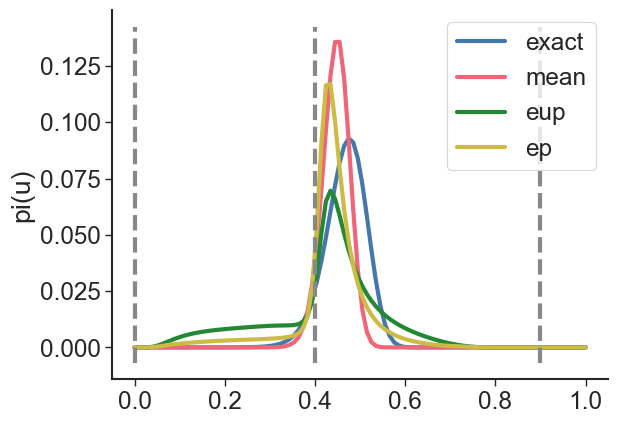

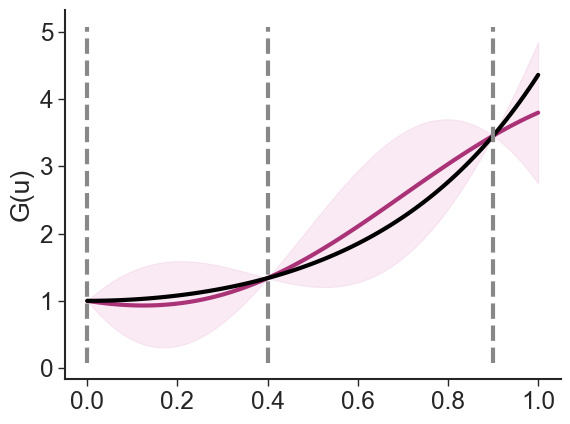

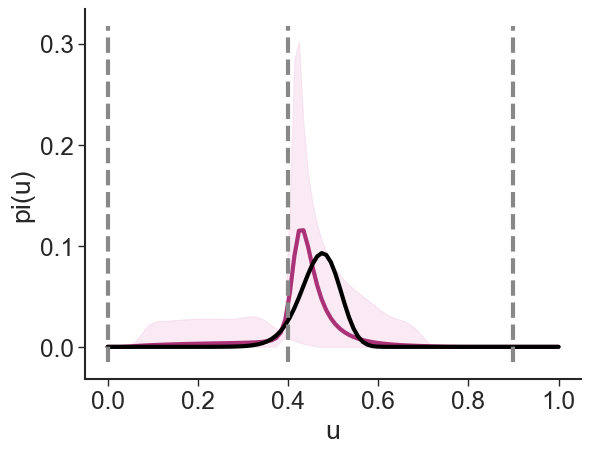

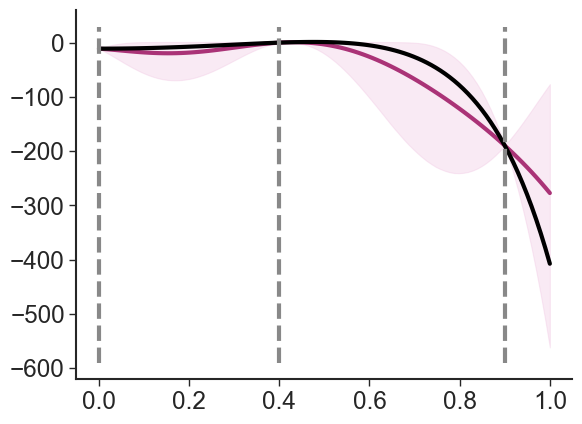

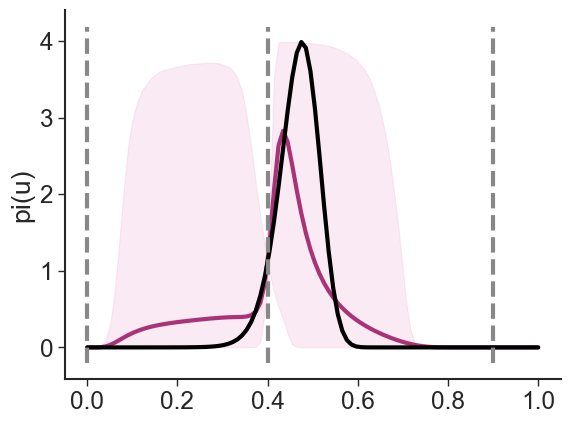

In [21]:
key, key_fwd_plots = jr.split(key)

save_fwd_em_plots(key=key_fwd_plots,
                  grid=grid, 
                  f_target=forward, 
                  post_em=fwd_post_surr,
                  post_true=posterior,
                  out_dir=out_dir,
                  gp_colors=gp_colors,
                  post_colors=colors,
                  interval_prob=interval_prob)

## Log-Density Surrogate

In [17]:
# same design inputs as forward model surrogate
ldens_design = gpx.Dataset(X=forward_design.X,
                           y=posterior.log_density(forward_design.X).reshape(-1, 1))

# fit GP surrogate
ldens_gp, _ = construct_gp(ldens_design, set_bounds=False, prior_mean='constant')

sd = jnp.sqrt(ldens_gp.prior.kernel.variance.get_value())
sd_new = 6 * sd
ldens_gp.prior.kernel.variance.set_value(sd_new ** 2)

ldens_surrogate = wrap_gp(ldens_gp, ldens_design, jitter)

# Induced posterior surrogate    
ldens_post_surr = LogDensGPSurrogateGrid(log_dens=ldens_surrogate, support=posterior.support)

In [18]:
ldens_post_surr.surrogate.gp.prior.kernel.variance

NonNegativeReal( # 1 (8 B)
  value=Array([272229.94753218], dtype=float64),
  tag='non_negative'
)

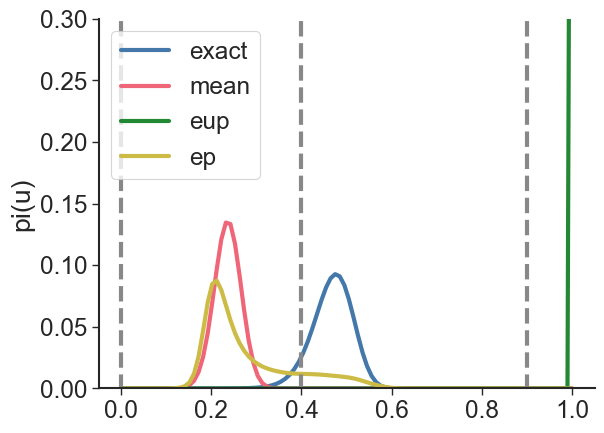

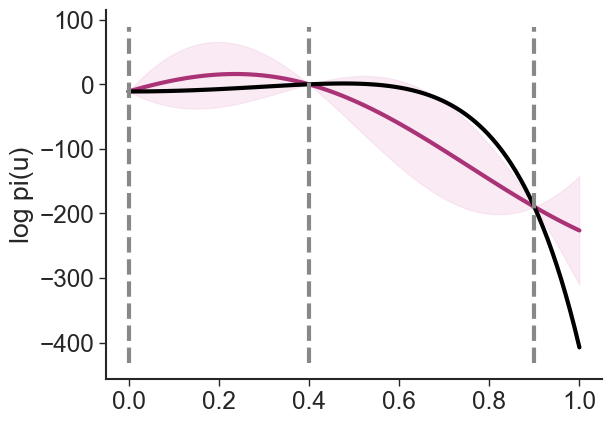

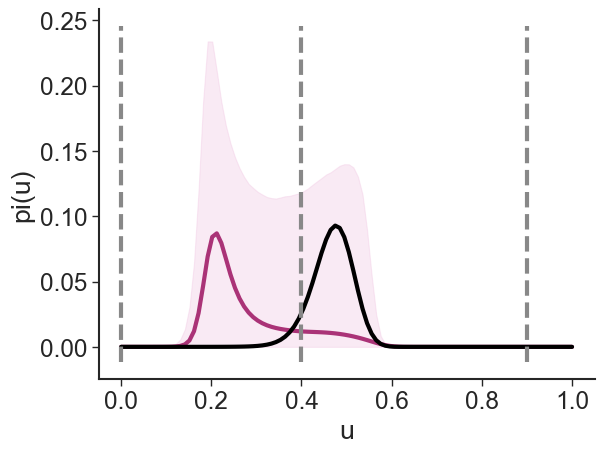

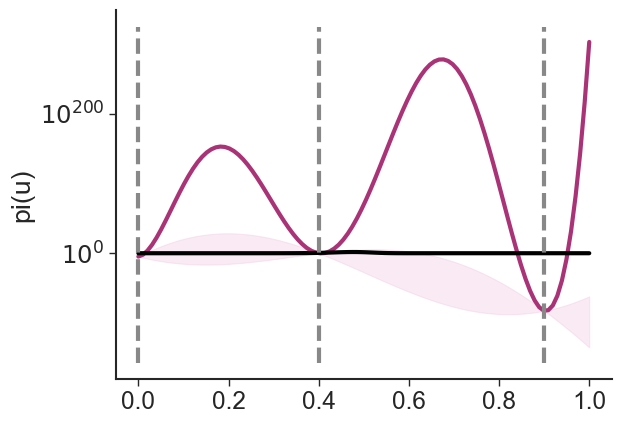

In [19]:
key, key_ldens_plots = jr.split(key)

save_ldens_em_plots(key=key_ldens_plots, 
                    grid=grid, 
                    f_target=posterior.log_density, 
                    post_em=ldens_post_surr, 
                    post_true=posterior, 
                    out_dir=out_dir, 
                    gp_colors=gp_colors, 
                    post_colors=colors,
                    interval_prob=interval_prob,
                    post_ylim=post_ylim)